In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, Input
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# **1. xử lý dataset**

# **1.1. load, shuffle, split**

In [4]:
batch_size = 350
num_classes = 10   # CIFAR-10
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
data_augmentation = True
epochs = 300

In [5]:
(X_train, y_train), (X_remain, y_remain) = cifar10.load_data()

print('X_train shape:', X_train.shape)   # 4D: images
print('y_train shape:', y_train.shape)   # 2D: labels
print('X_remain shape:', X_remain.shape)
print('y_remain shape:', y_remain.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_remain shape: (10000, 32, 32, 3)
y_remain shape: (10000, 1)


In [6]:
X_train[:1]  # array

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [7]:
y_train  # array

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.2, random_state=123)  # 20% test

# **1.2. encoding**

In [9]:
# one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
print('y_train shape:', y_train.shape)   # 2D
print('y_val shape:', y_val.shape)   # 2D
print('y_test shape:', y_test.shape)    # 2D

y_train shape: (50000, 10)
y_val shape: (8000, 10)
y_test shape: (2000, 10)


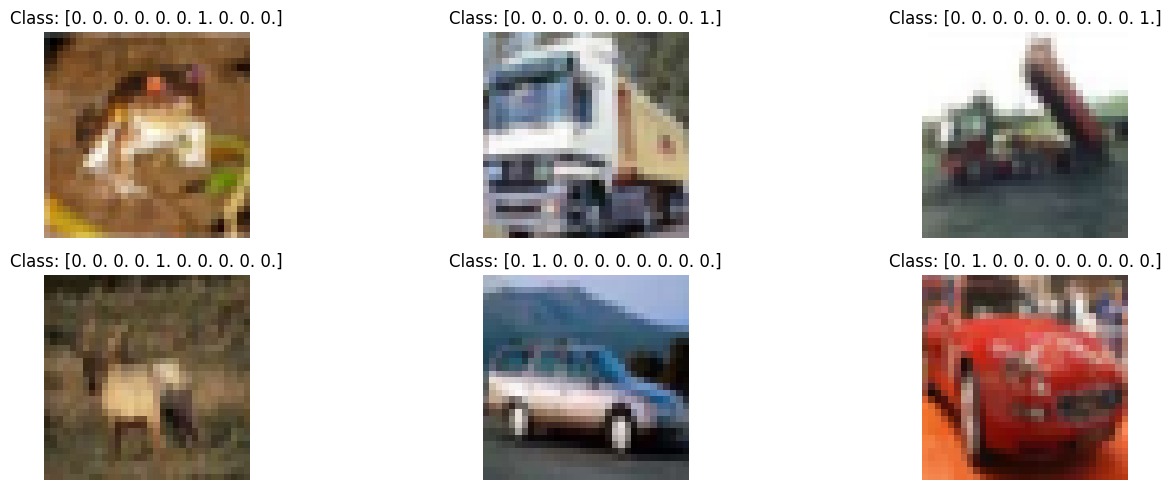

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

axes = axes.flatten()

for i in range(2 * 3):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
    axes[i].set_title(f"Class: {y_train[i]}")

plt.tight_layout()
plt.show()

# **1.3. Scaling**
-ko scale cho one-hot (vì nó 01 chỉ đại diện cho lớp, ko phải số lượng)

In [12]:
print("X_train type:", X_train.dtype)
print("X_val type:", X_val.dtype)
print("X_test type:", X_test.dtype)

print("y_train type:", y_train.dtype)
print("y_val type:", y_val.dtype)
print("y_test type:", y_test.dtype)

X_train type: uint8
X_val type: uint8
X_test type: uint8
y_train type: float64
y_val type: float64
y_test type: float64


In [13]:
# scale về khoảng [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [14]:
X_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

# **1.4. Tăng cường dữ liệu**
-chỉ đc tăng cường cho tập train

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,       # Quay ảnh ngẫu nhiên trong khoảng ±15 độ
    width_shift_range=0.1,   # Dịch chuyển ảnh theo chiều ngang tối đa 10%
    height_shift_range=0.1,  # Dịch chuyển ảnh theo chiều dọc tối đa 10%
    horizontal_flip=True,    # Lật ảnh ngang ngẫu nhiên
    zoom_range=0.1           # Thu phóng ảnh ngẫu nhiên 10%
)

datagen.fit(X_train)

# **2. Model**

In [16]:
model = Sequential()

inputs = Input(shape=(X_train.shape[1:]))

def add_conv(inputs, filters):
    res = Conv2D(filters, (3,3), padding='same')(inputs)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)

    res = Conv2D(filters, (3,3), padding='same')(res)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)

    return res

res = add_conv(inputs, 32)
res = MaxPooling2D(pool_size=(2,2))(res)
res = Dropout(0.25)(res)

res = add_conv(res, 64)
res = MaxPooling2D(pool_size=(2,2))(res)
res = Dropout(0.25)(res)

res = add_conv(res, 128)
res = MaxPooling2D(pool_size=(2,2))(res)
res = Dropout(0.25)(res)

res = Flatten()(res)

res = Dense(512)(res)
res = BatchNormalization()(res)
res = Activation('relu')(res)
res = Dropout(0.5)(res)

res = Dense(num_classes)(res)
outputs = Activation('softmax')(res)

model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(
    loss = CategoricalCrossentropy(from_logits = False),   # SparseCategoricalCrossentropy: ko cần one-hot y
    optimizer = Adam(learning_rate = 1e-3),
    metrics = ['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 10,
    restore_best_weights = True
)

if data_augmentation:
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs = 300,
        validation_data = (X_test, y_test),
        steps_per_epoch = len(X_train) // batch_size,  # tổng batch
        verbose = 1
    )
else:
    history = model.fit(
        X_train, y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        shuffle = True,
        verbose = 1,
        callbacks = [early_stopping]
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 54s 274ms/step - accuracy: 0.3059 - loss: 2.0689 - val_accuracy: 0.1090 - val_loss: 3.7315
Epoch 2/300
  1/142 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4857 - loss: 1.4991

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4857 - loss: 1.4991 - val_accuracy: 0.1090 - val_loss: 3.7296
Epoch 3/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.4908 - loss: 1.4131 - val_accuracy: 0.2145 - val_loss: 2.6712
Epoch 4/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5657 - loss: 1.3039 - val_accuracy: 0.2045 - val_loss: 2.6820
Epoch 5/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.5607 - loss: 1.2152 - val_accuracy: 0.4840 - val_loss: 1.4776
Epoch 6/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5943 - loss: 1.1503 - val_accuracy: 0.4875 - val_loss: 1.4540
Epoch 7/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.6154 - loss: 1.0744 - val_accuracy: 0.6610 - val_loss: 0.9574
Epoch 8/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 1.0527 - val_accuracy: 0.6530 - val_loss: 1.0010
Epoch 9/300
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.6578 - loss: 0.9623 - val_accu

In [18]:
model.save("/content/drive/MyDrive/image-classification/model/cnn_cifar10_model.keras")

# **3. Đánh giá**

In [19]:
model = load_model("/content/drive/MyDrive/image-classification/model/cnn_cifar10_model.keras")

In [20]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Val Loss: {loss:.4f}')
print(f'Val Accuracy: {accuracy:.4f}')

Val Loss: 0.5178
Val Accuracy: 0.8555


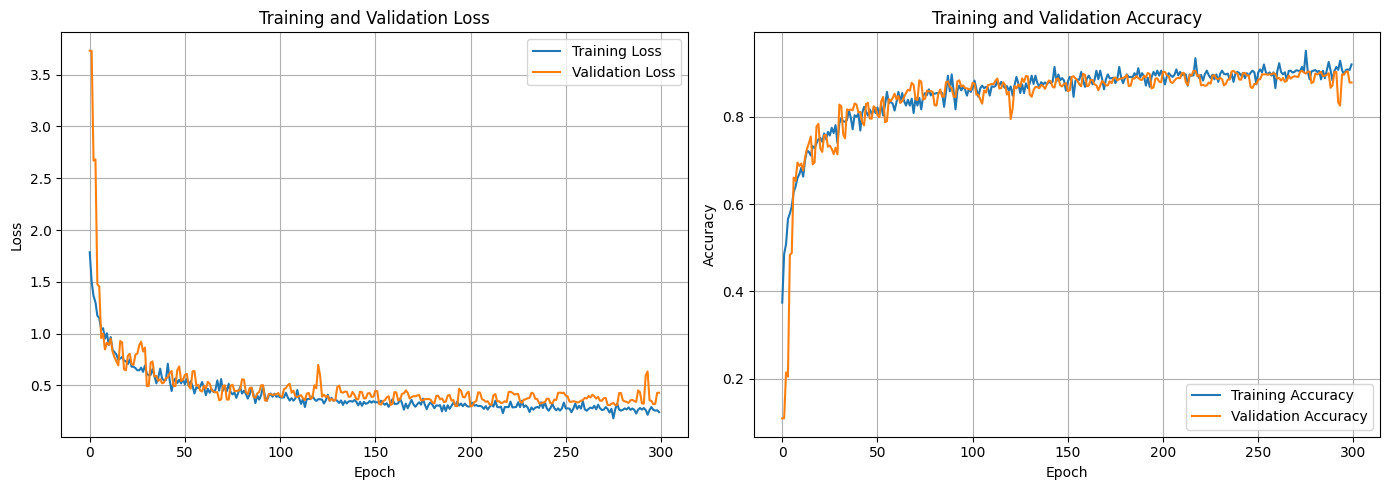

In [21]:
# Trích xuất lịch sử huấn luyện
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(len(train_loss))

# Thiết lập đồ thị
plt.figure(figsize=(14, 5))

# ----- Đồ thị Loss -----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ----- Đồ thị Accuracy -----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **3.1. Confusion matrix**

In [22]:
y_predict = model.predict(X_val)
y_predict[:2]   # 2D (10000, 10)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[7.0303440e-07, 3.5649109e-06, 2.0800310e-03, 2.3970339e-02,
        1.1195703e-05, 2.9183548e-06, 9.7391248e-01, 2.2040015e-06,
        1.5954690e-06, 1.4925150e-05],
       [6.0516449e-08, 9.9844980e-01, 9.7543289e-15, 1.1530825e-14,
        4.1287440e-16, 4.2491236e-17, 5.9930858e-12, 3.0628076e-16,
        2.8529028e-06, 1.5472280e-03]], dtype=float32)

In [23]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# decode
y_val = np.argmax(y_val, axis=1)  # axis=1: theo cột
y_val    # 1D (10000,)

array([6, 1, 8, ..., 3, 3, 6])

In [25]:
y_predict_idx = np.argmax(y_predict, axis=1)   # axis=1: theo cột
y_predict_idx   # 1D (10000,)

array([6, 1, 8, ..., 6, 6, 6])

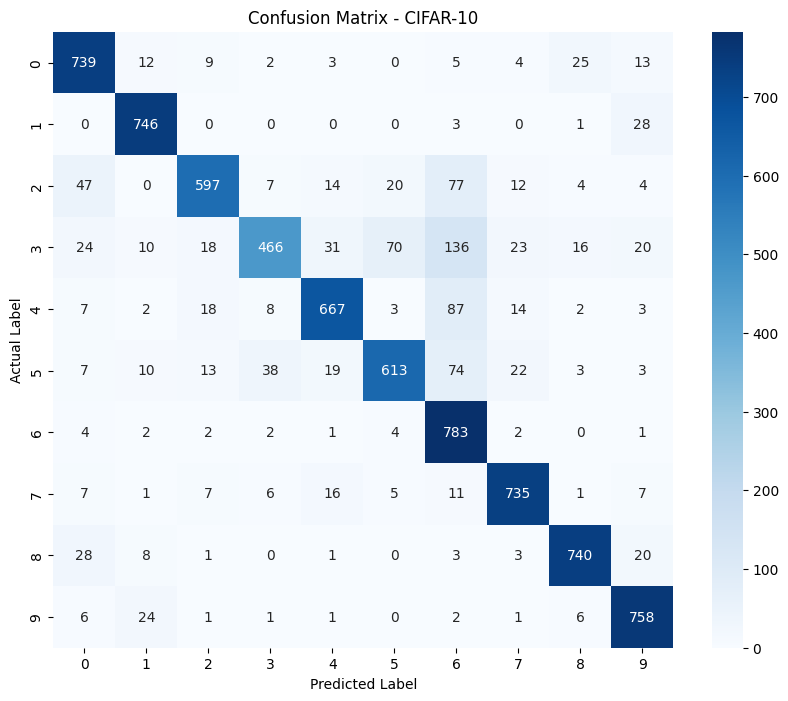

In [26]:
cf_maxtrix = confusion_matrix(y_val, y_predict_idx)

plt.figure(figsize=(10, 8))
sns.heatmap(cf_maxtrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CIFAR-10')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# **3.2. Show image**

In [27]:
def display(X_predict, y_predict, y_predict_idx, y_actual_idx, img_indices):
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))    # (fig, axes); axes: 2D (2, 5)
    fig.subplots_adjust(hspace=1)
    fig.tight_layout()
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        print(y_predict[indices_random[i]])

        actual_label = labels[y_actual_idx[i]]
        predicted_label = labels[y_predict_idx[i]]
        predicted_score = round(y_predict[img_indices[i]].max() * 100, 2)

        ax.imshow(X_predict[i])
        ax.set_title(f"Actual: {actual_label}\n Predicted: {predicted_label}\n Predicted_score: {predicted_score:.2f}%", color='green' if y_predict_idx[i] == y_actual_idx[i] else 'red')
        ax.axis('off')

[6.01614602e-06 1.36184881e-05 1.06747255e-01 7.21428752e-01
 1.11012300e-02 7.86243007e-02 7.03350604e-02 9.29953903e-03
 1.28632222e-04 2.31561880e-03]
[9.2392153e-01 8.9065338e-07 7.6006599e-02 3.7003814e-05 1.8937100e-05
 4.9423797e-06 4.8810975e-06 1.3509666e-06 1.1752320e-06 2.6363782e-06]
[4.4952253e-06 2.5143697e-06 2.9708591e-10 7.0621209e-10 3.0002195e-10
 1.0384259e-13 1.0285007e-10 1.3093309e-08 3.9058027e-06 9.9998903e-01]
[4.7985520e-03 6.4713022e-05 1.0128164e-03 3.2578075e-01 1.6413428e-01
 4.0990740e-01 1.5046077e-03 3.4952867e-03 1.0309351e-03 8.8270560e-02]
[3.6649709e-07 3.4132643e-08 1.8709926e-04 9.1557652e-03 9.8073560e-01
 9.3477014e-03 5.2331964e-04 3.4156827e-05 7.2999733e-06 8.7447097e-06]
[9.3848180e-16 1.1947225e-22 3.7569770e-14 2.7307391e-18 2.7101417e-09
 5.0526517e-11 2.9953527e-21 1.0000000e+00 5.9085974e-24 1.6302363e-20]
[2.05019707e-04 1.37748793e-01 5.89630957e-08 9.22310173e-10
 2.33701031e-10 3.68989173e-09 1.06474715e-07 1.82496429e-09
 2.290904

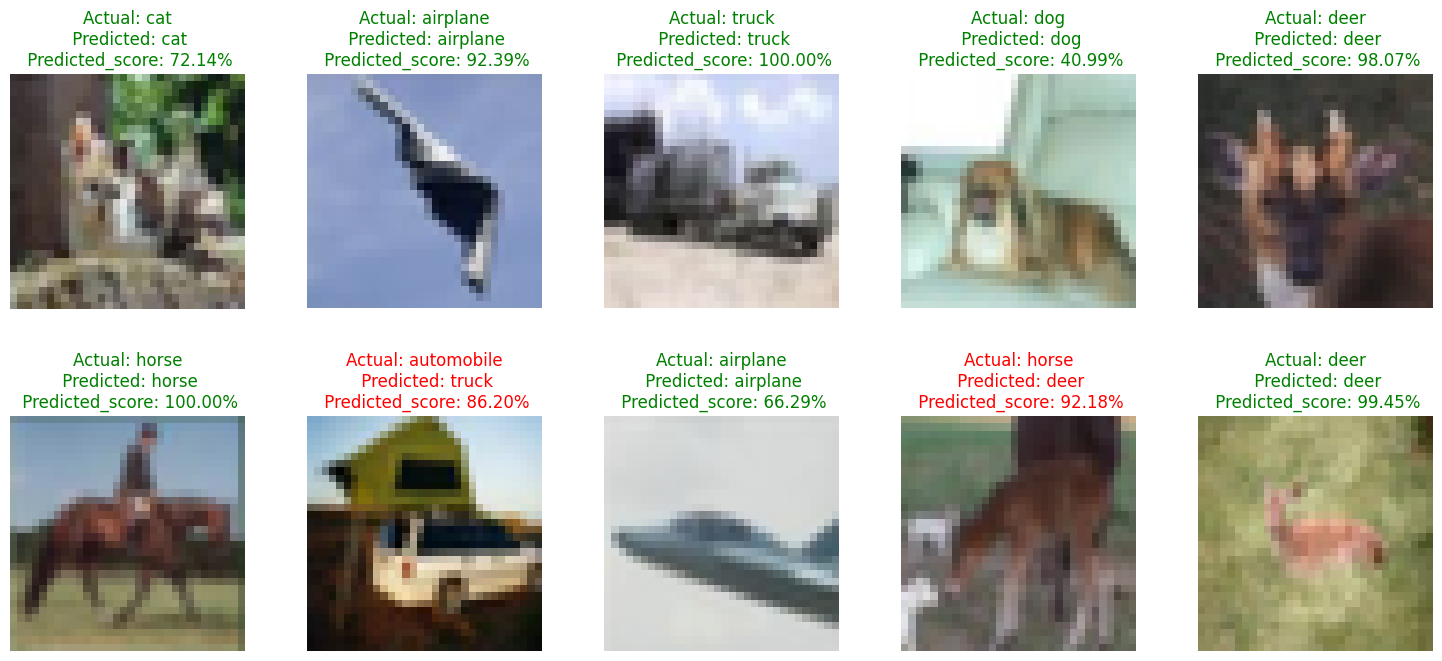

In [28]:
# # Hiển thị 10 ảnh ngẫu nhiên
indices_random = np.random.choice(len(X_val), 10, replace=False)   #replace=False: không lặp lại phần tử
images_random = X_val[indices_random]   # images = np.array([X_val[0],...])
y_actual_random = y_val[indices_random]
y_predict_idx_random = y_predict_idx[indices_random]

display(images_random, y_predict, y_predict_idx_random, y_actual_random, indices_random)

# **4. Dự đoán**

In [29]:
idx_rd1 = random.randint(0, len(X_test) - 1)
img1 = X_test[idx_rd1]
img1.shape   # 3D

(32, 32, 3)

In [30]:
X_predict1 = np.expand_dims(img1, 0)  # thêm chiều
X_predict1.shape  # 4D

(1, 32, 32, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Text(0.5, 1.0, 'Actual: frog\n Predicted: frog\n Predicted_score: 100.00%')

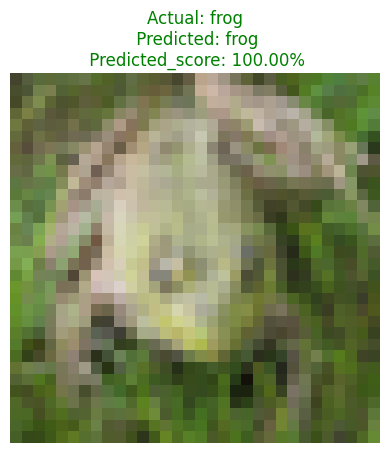

In [44]:
y_predict1 = model.predict(X_predict1)  # 2D (1, 10)

actual_label1 = labels[np.argmax(y_test[idx_rd1])]
predicted_label1 = labels[y_predict1[0].argmax()]
predicted_score1 = round(y_predict1[0].max() * 100, 2)   # np.max(y_predict1[0])

plt.imshow(img1)
plt.axis('off')
plt.title(f"Actual: {actual_label1}\n Predicted: {predicted_label1}\n Predicted_score: {predicted_score1:.2f}%", color='green' if np.argmax(y_predict1[0]) == np.argmax(y_test[idx_rd1]) else 'red')